In [1]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
x = iris.data[:, 2:]  # petal length and width
y = iris.target

print(iris.feature_names[2:], y)

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(x, y)

['petal length (cm)', 'petal width (cm)'] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [2]:
from sklearn.tree import export_graphviz
import os

PROJECT_ROOT_DIR = "datasets"
CHAPTER_ID = "decision_trees"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

# export_graphviz(
#     tree_clf,
#     out_file=image_path('iris_tree.dot'),
#     feature_names=iris.feature_names[2:],
#     class_names=iris.target_names,
#     rounded=True,
#     filled=True
# )

![image.png](datasets/images/decision_trees/iris_tree.png)

![image.png](datasets/expression/基尼不纯度.PNG)

计算方式 1–（0/54）^2–（49/54）^2–（5/54）^2≈0.168

In [3]:
# 估算概率
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [4]:
# 估算类别
tree_clf.predict([[5,1.5]])

array([1])

**CART训练算法**

*Scikit-Learn使用的是分类与回归树（Classification And Regression Tree，简称CART）算法来训练决策树（也叫作“生长”树）*

![image.png](datasets/expression/CART成本函数.png)

*CART是一种贪婪算法： 从顶层开始搜索最优分裂， 然后每层重复这个过程。 
几层分裂之后， 它并不会检视这个分裂的不纯度是否为可能的最低值。 
贪婪算通常会产生一个相当不错的解， 但是不能保证是最优解。*


**计算复杂度**

In [5]:
# 行预测需要从根到叶遍历决策树。 通常来说， 决策树大致平衡， 因此遍历决策树需要经历大约O（log2（m） ） 个节点。 
# （注：log2是以2为底的对数。 等于log2（m） =log（m） /log（2）。） 
# 而每个节点只需要检查一个特征值， 所以总体预测复杂度也只是O（log2（m） ） ， 与特征数量无关。 
# 如此， 即便是处理大型数据集，预测也很快。

# 但是， 训练时在每一个节点， 算法都需要在所有样本上比较所有特征（如果设置了max_features会少一些） 。 
# 这导致训练的复杂度为O（n×m log（m） ）。 
# 对于小型训练集（几千个实例以内），ScikitLearn可以通过对数据预处理（设置presort=True）来加快训练， 但是
# 对于较大训练集而言， 可能会减慢训练的速度。

**基尼不纯度还是信息熵**

In [6]:
# 可以使用criterion='entropy'来选择信息熵来作为不纯度的测量方式。
# 如深度为2的左侧节点的熵值为:-49/54 log(49/54) -5/54 log(5/54)≈0.31

**正则化超参数**

In [7]:
# 为避免过度拟合， 需要在训练过程中降低决策树的自由度。 现在你应该知道， 这个过程被称为正则化。 

In [8]:
# 减小max_depth可使模型正则化， 从而降低过度拟合的风险。
# DecisionTreeClassifier类还有一些其他的参数， 同样可以限制决策树的形状： 
# min_samples_split（分裂前节点必须有的最小样本数）， 
# min_samples_leaf（叶节点必须有的最小样本数量），
# min_weight_fraction_leaf（跟min_samples_leaf一样， 但表现为加权实例总数的占比）， 
# max_leaf_nodes（最大叶节点数量） ， 
# max_features（分裂每个节点评估的最大特征数量） 。 
# 增大超参数min_*或是减小max_*将使模型正则化

# 如果一个节点的子节点全部为叶节点， 则该节点可被认为不必要， 除非它所表示的纯度提升有重要的统计意义。
# 如果这个概率（称之为p值） 高于一个给定阈值（通常是5%， 由超参数控制），那么这个节点可被认为不必要，其子节点可被删除。 
# 直到所有不必要的节点都被删除， 剪枝过程结束。

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris-Setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris-Versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris-Virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

In [10]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

print(ym)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

[0 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 1 0
 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1
 0 0 0 1 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1 0 1 0 1 0 0 0]


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=4, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

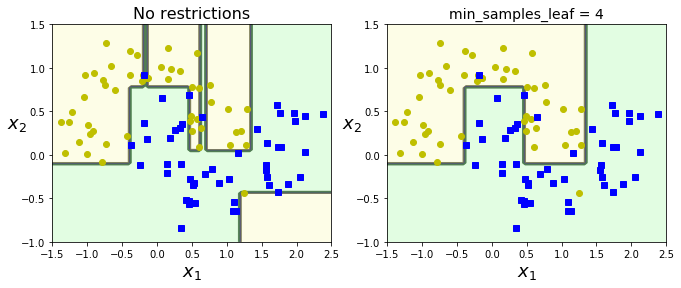

In [11]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("No restrictions", fontsize=16)
plt.subplot(122)
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.5, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)

plt.show()

**回归**

In [12]:
# Quadratic training set + noise
np.random.seed(42)
m = 200
X = np.random.rand(m, 1)
y = 4 * (X - 0.5) ** 2
y = y + np.random.randn(m, 1) / 10

In [20]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=2)
tree_reg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

Text(0.5, 1.0, 'min_samples_leaf = 10')

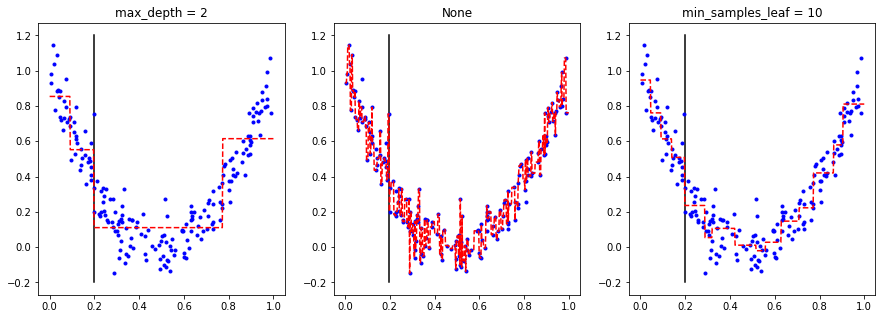

In [26]:
# export_graphviz(
#     tree_reg,
#     out_file=image_path('regress_training.dot'),
#     feature_names=['X'],
#     class_names= y,
#     rounded=True,
#     filled=True
# )
axes = [0, 1, -0.2, 1]
x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
y_pred = tree_reg.predict(x1)

# 无超参正则化
tree_reg1 = DecisionTreeRegressor()
tree_reg1.fit(X, y)
y_pred1 = tree_reg1.predict(x1)

# 超参正则化
tree_reg2 = DecisionTreeRegressor(min_samples_leaf=10)
tree_reg2.fit(X, y)
y_pred2 = tree_reg2.predict(x1)

plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(np.linspace(0.197,0.197, 500).reshape(-1, 1) , np.linspace(-0.2,1.2, 500).reshape(-1, 1) , 'k-')
plt.plot(X , y , 'b.')
plt.plot(x1 , y_pred, 'r--')
plt.title("max_depth = 2")

plt.subplot(132)
plt.plot(np.linspace(0.197,0.197, 500).reshape(-1, 1) , np.linspace(-0.2,1.2, 500).reshape(-1, 1) , 'k-')
plt.plot(X , y , 'b.')
plt.plot(x1 , y_pred1, 'r--')
plt.title("None")

plt.subplot(133)
plt.plot(np.linspace(0.197,0.197, 500).reshape(-1, 1) , np.linspace(-0.2,1.2, 500).reshape(-1, 1) , 'k-')
plt.plot(X , y , 'b.')
plt.plot(x1 , y_pred2, 'r--')
plt.title("min_samples_leaf = 10")

![image.png](datasets/images/decision_trees/regress_training.png)

**1.如果训练集有100万个实例， 训练决策树（无约束） 大致的深度是多少？**

1.一个包含m个叶节点的均衡二叉树的深度等于log2（m）（注：log2表示以2为底的log函数， log2（m） =log（m） /log（2）。）的四舍五入。 
通常来说，二元决策树训练到最后大体都是平衡的，如果不加以限制，最后平均每个叶节点一个实例。 
因此，如果训练集包含一百万个实例， 那么决策树深度约等于log2（10^6） ≈20层（实际上会更多一些， 因为决策树通常不可能完美平衡） 。

**2.通常来说， 子节点的基尼不纯度是高于还是低于其父节点？是通常更高/更低？ 还是永远更高/更低？**

一个节点的基尼不纯度通常比其父节点低。这是通过CART训练算法的成本函数确保的。
该算法分裂每个节点的方法，就是使其子节点的基尼不纯度的加权之和最小。但是，如果一个子节点的不纯度远小于另一个，那么也有可能使子节点的基尼不纯度比其父节点高，只要那个不纯度更低的子节点能够抵偿这个增加即可。 
举例来说，假设一个节点包含4个A类别的实例和1个B类别的实例，其基尼不纯度等于1-(1/5)^2-(4/5)^2=0.32。 
现在我们假设数据集是一维的，并且实例的排列顺序如下： A， B， A， A， A。 
你可以验证，算法将在第二个实例后拆分该节点， 从而生成两个子节点所包含的实例分别为A， B和A， A， A。 
第一个子节点的基尼不纯度为1-(1/2)^2-(1/2)^2=0.5，比其父节点要高。 
这是因为第二个子节点是纯的，所以总的加权基尼不纯度等于(2/5)*0.5+(3/5)*0=0.2，低于父节点的基尼不纯度。

**3.如果决策树过度拟合训练集， 减少max_depth是否为一个好主意？**

如果决策树过度拟合训练集， 降低max_depth可能是一个好主意， 因为这会限制模型， 使其正则化。

**4.如果决策树对训练集拟合不足， 尝试缩放输入特征是否为一个好主意？**

决策树的优点之一就是它们不关心训练数据是否缩放或是集中， 所以如果决策树对训练集拟合不足， 缩放输入特征不过是浪费时间罢了。

**5.如果在包含100万个实例的训练集上训练决策树需要一个小时，那么在包含1000万个实例的训练集上训练决策树，大概需要多长时间？**

决策树的训练复杂度为O（n×mlog（m））。所以，如果将训练集大小乘以10，训练时间将乘以K=（n×10m×log（10m））/（n×m×log（m）） =10×log（10m）/log（m） 。 
如果m=106， 那么K≈11.7， 所以训练1000万个实例大约需要11.7小时

**6.如果训练集包含100000个实例， 设置presort=True可以加快训练么？**

只有当数据集小于数千个实例时， 预处理训练集才可以加速训练。 如果包含100000个实例， 设置presort=True会显著减慢训练。


# 7.为卫星数据集训练并微调一个决策树。

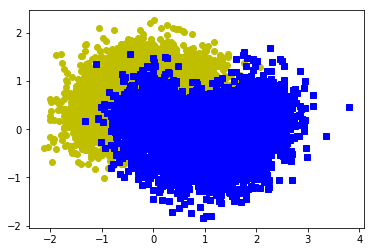

In [35]:
# a.使用make_moons（n_samples=10000， noise=0.4） 生成一个卫星数据集。
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=10000, noise=0.4)

plt.plot(x[:,0][y==0], x[:,1][y==0], 'yo')
plt.plot(x[:,0][y==1], x[:,1][y==1], 'bs')

In [43]:
from sklearn.model_selection import train_test_split

# b.使用train_test_split（） 拆分训练集和测试集。
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# c.使用交叉验证的网格搜索（在GridSearchCV的帮助下） 为DecisionTree-Classifier找到适合的超参数。 提示： 尝试max_leaf_nodes的多种值。
params = {'max_leaf_nodes': list(range(2, 100)), 'min_samples_split': [2, 3, 4]}
grid_search_cv = GridSearchCV(
    DecisionTreeClassifier(random_state=42), 
    params, n_jobs=-1, verbose=1, cv=3)

grid_search_cv.fit(x_train, y_train)

Fitting 3 folds for each of 294 candidates, totalling 882 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 882 out of 882 | elapsed:    5.2s finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'min_samples_split': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       s

In [45]:
grid_search_cv.best_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=48,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [47]:
# d.使用超参数对整个训练集进行训练， 并测量模型在测试集上的性能。 你应该得到约85%到87%的准确率。

d_clf = DecisionTreeClassifier(random_state=42,
                               max_leaf_nodes=48,
                               min_samples_split=4)
d_clf.fit(x_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=48,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=4,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

In [51]:
y_pred = d_clf.predict(x_test)

# 验证准确率
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.857

# 8.种植一片森林。

In [53]:
# a.继续之前的练习， 生产1000个训练集子集， 每个子集包含随机挑选的100个实例。 提示： 使用Scikit-Learn的ShuffleSplit来实现。
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(x_train)-n_instances, random_state=42)
for mini_train_index, mini_test_index in rs.split(x_train):
    x_mini_train = x_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((x_mini_train, y_mini_train))

In [55]:
# b.使用前面得到的最佳超参数值， 在每个子集上训练一个决策树。 在测试集上评估这1000个决策树。 
# 因为训练集更小， 所以这些决策树的表现可能比第一个决策树要差一些， 只能达到约80%的准确率。
from sklearn.base import clone

forest = [clone(grid_search_cv.best_estimator_) for _ in range(n_trees)]

accuracy_scores = [] 

for tree, (x_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(x_mini_train, y_mini_train)
    
    y_pred = tree.predict(x_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))
    
np.mean(accuracy_scores)

0.7887445000000001

In [61]:
# c.见证奇迹的时刻到了。用每个测试集实例，生成1000个决策树的预测，然后仅保留次数最频繁的预测（可以使用SciPy的mode（）函数）。
# 这样你在测试集上可获得大多数投票的预测结果。

Y_pred = np.empty([n_trees, len(x_test)], dtype=np.uint8)
print(Y_pred.shape)
for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(x_test)
Y_pred

(1000, 2000)


array([[0, 1, 1, ..., 1, 0, 1],
       [0, 1, 0, ..., 0, 0, 1],
       [0, 1, 1, ..., 1, 0, 1],
       ...,
       [0, 1, 1, ..., 1, 0, 1],
       [0, 1, 1, ..., 1, 0, 1],
       [0, 1, 1, ..., 0, 0, 1]], dtype=uint8)

In [66]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)
print(y_pred_majority_votes, n_votes)
print(y_pred_majority_votes.shape, n_votes.shape)

[[0 1 1 ... 1 0 1]] [[897 960 964 ... 922 860 888]]
(1, 2000) (1, 2000)


In [67]:
# d.评估测试集上的这些预测， 你得到的准确率应该比第一个模型更高（高出0.5%～1.5%） 。 
# 恭喜， 你已经训练出了一个随机森林分类器！

accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))


0.866